# Part1 Autoencoders (30 points):

<p>
Your first task is to adapt the code from class to create a CNN-based autoencoder instead of the fully-connected one. 

Take a look at the DCGAN example to see how to use the upconvolution.

Use three conv layers with 32, 64, 128 for the encoder. 

The dimensionality of the latent space should be flexible as an input to the constructor and set per default to 100. 

Use 128, 64, 32 as your symmetric decoder.

Run the autoencoder on MNIST for 20 epochs with Adam and lr=0.001, using the standard MSE loss and with a latent space dimensionality of d = 2.

Now visualize each digit of the trainset of MNIST in the latent space similar to how we did this in class.

What can you say about the clustering of digits? 

Compare this to the fully-connected version from class? 

Do you think the CNN-version of the AE is better??

Re-train the autoencoder with a latent space of d = 10 and d = 50 and compare the MSE-loss for all three autoencoders, as well as discuss the quality of reconstruction.

</p>

In [1]:
%matplotlib inline
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision as tv
from torchvision import transforms, utils
import glob
import pickle
import time
from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh

In [2]:
# FC model from class
class AE_FC(nn.Module):
    def __init__(self, latent_dim):
        super(AE_FC,self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 784)
        )

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    
# FC model from class
class AE_FC_deep(nn.Module):
    def __init__(self, latent_dim):
        super(AE_FC_deep,self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784)
        )
    
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    # we define this function so we can access only the
    # latent space of the model
    def getlatent(self,x):
        x = self.encoder(x)
        return x

In [3]:
import torch.nn as nn

# Define a custom neural network class for an Autoencoder with a convolutional architecture.
class AE_CNN(nn.Module):
    def __init__(self, latent_dim):
        super(AE_CNN, self).__init__()

        # Encoder architecture
        self.encoder = nn.Sequential(
            # Convolutional layer 1: Input channel=1, Output channel=32, Kernel size=4x4, Stride=2, Padding=1
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),  # Batch normalization for better training stability

            # Convolutional layer 2: Input channel=32, Output channel=64, Kernel size=4x4, Stride=2, Padding=1
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            # Convolutional layer 3: Input channel=64, Output channel=128, Kernel size=3x3, Stride=2, Padding=1
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            # Convolutional layer 4: Input channel=128, Output channel=latent_dim, Kernel size=1x1, Stride=1, Padding=1
            nn.Conv2d(128, latent_dim, kernel_size=1, stride=1, padding=1, bias=False),
            nn.ReLU()
        )

        # Decoder architecture
        self.decoder = nn.Sequential(
            # Transpose convolutional layer 1: Input channel=latent_dim, Output channel=128, Kernel size=1x1, Stride=1, Padding=1
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=1, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Transpose convolutional layer 2: Input channel=128, Output channel=64, Kernel size=3x3, Stride=2, Padding=1
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # Transpose convolutional layer 3: Input channel=64, Output channel=32, Kernel size=4x4, Stride=2, Padding=1
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            # Transpose convolutional layer 4: Input channel=32, Output channel=1, Kernel size=4x4, Stride=2, Padding=1
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Sigmoid()  # Sigmoid activation for pixel values in the range [0, 1]
        )

    # Forward pass through the autoencoder
    def forward(self, x):
        x = self.encoder(x)  # Pass input through the encoder
        x = self.decoder(x)  # Pass the encoder's output through the decoder
        return x

    # Get the latent representation of an input without decoding
    def get_latent(self, x):
        x = self.encoder(x)  # Pass input through the encoder
        return x


In [4]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = tv.datasets.MNIST(root='./',  train=True,download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=1)
testset = tv.datasets.MNIST(root='./', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=1)

100%|██████████| 9912422/9912422 [00:00<00:00, 14303258.73it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 6606440.54it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 4889252.31it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4588277.64it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
def convertBatchToCombined(inp,out):
    # this should be extended to arbitrary batch length
    # assuming this to be 10 here
    combinedUp = np.zeros((28,28*10))
    combinedDown = np.zeros((28,28*10))
    for b in np.arange(10):
        combinedUp[:,b*28:b*28+28]=np.reshape(inp[:,b],(28,28))
        combinedDown[:,b*28:b*28+28]=np.reshape(out[:,b],(28,28))
    tmp = np.vstack([combinedUp,combinedDown])
    tmp = (tmp-tmp.min())/(tmp.max()-tmp.min())*255.
    return(np.repeat(tmp[:,:,np.newaxis], 3, axis=2))


# Fully Connected AutoEncoder

In [6]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from ipywidgets import interact
fig = make_subplots(rows=1, cols=1)
fig.append_trace(go.Image(z=np.zeros((28,28*10,3))),row=1,col=1)
fig = go.FigureWidget(fig)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
)
fig

FigureWidget({
    'data': [{'type': 'image',
              'uid': '2b9e9fdf-f5fe-4725-bdd3-461fbeeaac37',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.],
                           ...,
                           [0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.]],
                   
                          [[0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.],
                           ...,
                           [0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.]],
                   
                          [[0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.],
                           ...,
                           [0., 0., 0.],
                           [0., 0., 0.],
  

In [7]:

##########################################################################
### Training the Fully Connected autoencoder with a latent dimension of 2 
##########################################################################

# Set the number of training epochs
num_epochs = 20

# Initialize the autoencoder model (AE_FC_deep) with a latent dimension of 2
model = AE_FC_deep(2)

# Choose the device for training (GPU if available, otherwise CPU)
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

# Move the model to the selected device (GPU or CPU)
model.to(device=device)

# Define the Mean Squared Error (MSE) loss function
distance = nn.MSELoss()

# Use the Adam optimizer for training with a learning rate of 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Pre-load test images for visualization of online prediction
timg, tlabels = list(dataloader)[0]
timg = timg.to(device)
timg = timg.view(timg.size(0), -1)

# Training loop
for epoch in range(num_epochs):
    for n_batch, data in enumerate(dataloader):
        # Extract image data and move them to the selected device
        img, labels = data[0].to(device), data[1].to(device)

        # Flatten the input images
        img = img.view(img.size(0), -1)
        
        # Forward pass: compute the output of the model and calculate the MSE loss
        output = model(img)
        loss_mse = distance(output, img)
        
        # Backward pass: zero the gradients, compute gradients, and perform optimization step
        optimizer.zero_grad()
        loss_mse.backward()
        optimizer.step()

        # Visualize the output periodically
        if (n_batch) % 50 == 0:
            with torch.no_grad():
                output = model(timg)
                inp = timg[0:10, :].detach().cpu()
                out = output[0:10, :].detach().cpu()

                # Combine input and output images for visualization
                combined = convertBatchToCombined(inp.permute(1,0), out.permute(1,0))

                # Update the Plotly figure with the new data
                with fig.batch_update():
                    fig.data[0]['z'] = combined
                    fig.update_layout(
                        title={
                            'text': 'epoch {0:} batch {1:} L={2:.3f}'.format(epoch+1, n_batch, loss_mse.item()),
                            'xanchor': 'center',
                            'x': 0.5
                        })
    # Log the current loss for the epoch
    print('epoch [{}/{}], loss: {:.4f}'.format(epoch+1, num_epochs, loss_mse.item()))


epoch [1/20], loss: 0.0462
epoch [2/20], loss: 0.0422
epoch [3/20], loss: 0.0433
epoch [4/20], loss: 0.0371
epoch [5/20], loss: 0.0383
epoch [6/20], loss: 0.0379
epoch [7/20], loss: 0.0379
epoch [8/20], loss: 0.0362
epoch [9/20], loss: 0.0371
epoch [10/20], loss: 0.0362
epoch [11/20], loss: 0.0364
epoch [12/20], loss: 0.0357
epoch [13/20], loss: 0.0355
epoch [14/20], loss: 0.0340
epoch [15/20], loss: 0.0380
epoch [16/20], loss: 0.0336
epoch [17/20], loss: 0.0361
epoch [18/20], loss: 0.0373
epoch [19/20], loss: 0.0339
epoch [20/20], loss: 0.0339


In [8]:
def train_AE_CNN(num_epochs, latent_dim):
    # Create an instance of the AE_CNN autoencoder model
    model = AE_CNN(latent_dim)

    # Determine the device (GPU if available, otherwise CPU)
    device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

    # Move the model to the selected device
    model.to(device=device)

    # Define the Mean Squared Error (MSE) loss function
    distance = nn.MSELoss()

    # Use the Adam optimizer for training with a learning rate of 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # List to store loss values for each epoch
    epoch_losses = []

    # Pre-load test images for visualization of online prediction
    timg, tlabels = list(dataloader)[0]
    timg = timg.to(device)

    # Iterate over the specified number of training epochs
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        batch_count = 0

        # Iterate over batches in the dataloader
        for n_batch, data in enumerate(dataloader):
            # Extract image data and move them to the selected device
            img, labels = data[0].to(device), data[1].to(device)

            # Forward pass: compute the output of the model and calculate the MSE loss
            output = model(img)
            loss_mse = distance(output, img)

            # Backward pass: zero the gradients, compute gradients, and perform optimization step
            optimizer.zero_grad()
            loss_mse.backward()
            optimizer.step()

            epoch_loss += loss_mse.item()
            batch_count += 1

            # Visualize the output periodically
            if (n_batch) % 50 == 0:
                with torch.no_grad():
                    output = model(timg)
                    inp = timg[0:10, :].detach().cpu()
                    out = output[0:10, :].detach().cpu()
                    combined = convertBatchToCombined(inp.permute(1,0,2,3),out.permute(1,0,2,3))
                
                    with fig.batch_update():
                        fig.data[0]['z'] = combined
                        fig.update_layout(
                            title={
                                'text':'epoch {0:} batch {1:} L={2:.3f}'.format(
                                    epoch+1,n_batch,loss_mse.item()),
                                'xanchor':'center',
                                'x':0.5
                            })

        average_loss = epoch_loss / batch_count
        epoch_losses.append(average_loss)

        # Log the current loss for the epoch
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss_mse.item()))

    # Create a scatter plot of the 2D latent space representations for each digit
    plt.figure(figsize=(10, 10))
    
    # Create a DataLoader to sort the training data
    dataloaderSorted = torch.utils.data.DataLoader(trainset, batch_size=60000, shuffle=False, num_workers=4)

    for n_batch, data in enumerate(dataloaderSorted):
        img, labels = data[0].to(device), data[1].detach().cpu().numpy()

    # Set the model to evaluation mode
    model.eval()
    model.to(device)

    # Iterate over each digit label (0-9)
    for l in np.arange(10):
        # Find the indices corresponding to the current label
        inds = labels == l
        # Select the images with the current label
        tmp = img[inds, :, :, :]
        tmp.to(device)

        # Get the 2D latent space representation for the selected images
        output = model.get_latent(tmp).detach().cpu().numpy()

        # Create a scatter plot of the latent space representation with the label as the digit string
        plt.scatter(output[:, 0], output[:, 1], label=str(l))

    # Add a legend to the plot
    plt.legend()
    # Show the plot
    plt.show()

    return epoch_losses


In [9]:

import plotly.graph_objs as go
from plotly.subplots import make_subplots
from ipywidgets import interact


fig = make_subplots(rows=1, cols=1)
fig.append_trace(go.Image(z=np.zeros((28,28*10,3))),row=1,col=1)
fig = go.FigureWidget(fig)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
)
fig

FigureWidget({
    'data': [{'type': 'image',
              'uid': 'dc0ec77e-dd0d-47ea-8827-0efb35f23db6',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.],
                           ...,
                           [0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.]],
                   
                          [[0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.],
                           ...,
                           [0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.]],
                   
                          [[0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.],
                           ...,
                           [0., 0., 0.],
                           [0., 0., 0.],
  

# Comparing MSE Loss Across Different Latent Dimensions

Training with latent_dim = 2


epoch [1/20], loss:0.0121
epoch [2/20], loss:0.0106
epoch [3/20], loss:0.0092
epoch [4/20], loss:0.0085
epoch [5/20], loss:0.0081
epoch [6/20], loss:0.0070
epoch [7/20], loss:0.0074
epoch [8/20], loss:0.0078
epoch [9/20], loss:0.0062
epoch [10/20], loss:0.0065
epoch [11/20], loss:0.0057
epoch [12/20], loss:0.0064
epoch [13/20], loss:0.0072
epoch [14/20], loss:0.0060
epoch [15/20], loss:0.0069
epoch [16/20], loss:0.0058
epoch [17/20], loss:0.0060
epoch [18/20], loss:0.0066
epoch [19/20], loss:0.0059
epoch [20/20], loss:0.0056


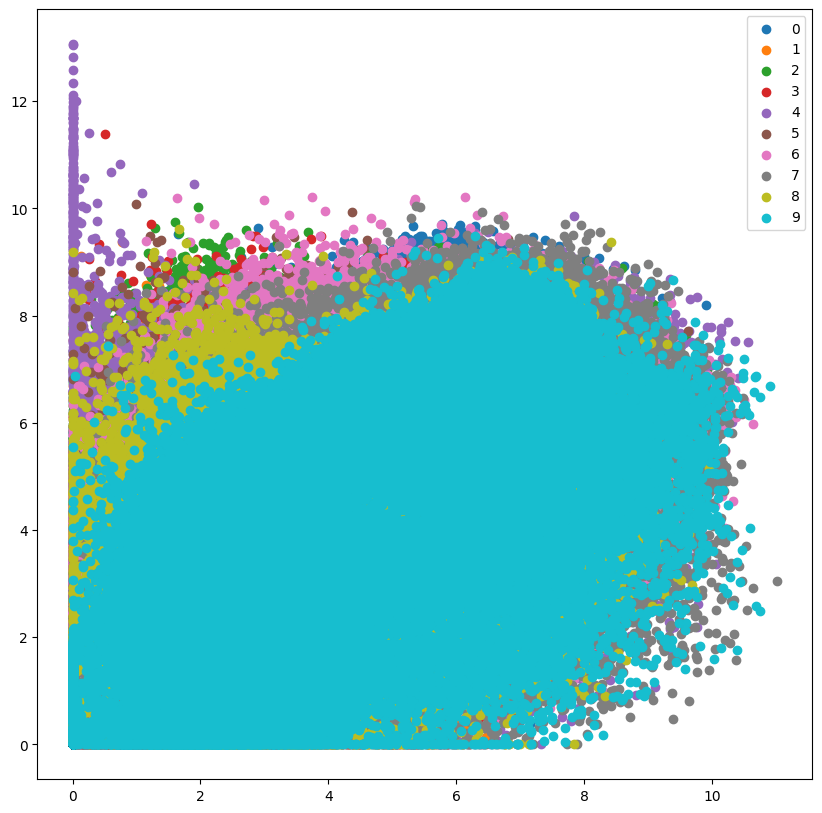

Training with latent_dim = 10
epoch [1/20], loss:0.0031
epoch [2/20], loss:0.0026
epoch [3/20], loss:0.0022
epoch [4/20], loss:0.0019
epoch [5/20], loss:0.0017
epoch [6/20], loss:0.0019
epoch [7/20], loss:0.0019
epoch [8/20], loss:0.0019
epoch [9/20], loss:0.0017
epoch [10/20], loss:0.0018
epoch [11/20], loss:0.0015
epoch [12/20], loss:0.0014
epoch [13/20], loss:0.0015
epoch [14/20], loss:0.0015
epoch [15/20], loss:0.0014
epoch [16/20], loss:0.0014
epoch [17/20], loss:0.0012
epoch [18/20], loss:0.0014
epoch [19/20], loss:0.0015
epoch [20/20], loss:0.0015


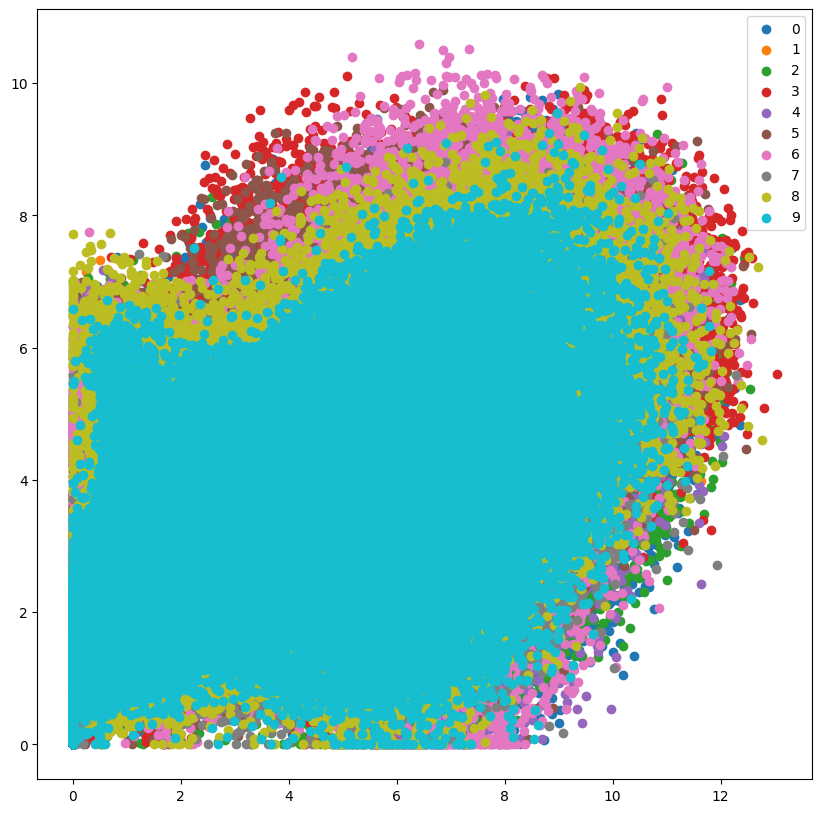

Training with latent_dim = 50
epoch [1/20], loss:0.0033
epoch [2/20], loss:0.0017
epoch [3/20], loss:0.0017
epoch [4/20], loss:0.0013
epoch [5/20], loss:0.0012
epoch [6/20], loss:0.0008
epoch [7/20], loss:0.0008
epoch [8/20], loss:0.0009
epoch [9/20], loss:0.0008
epoch [10/20], loss:0.0009
epoch [11/20], loss:0.0008
epoch [12/20], loss:0.0009
epoch [13/20], loss:0.0006
epoch [14/20], loss:0.0006
epoch [15/20], loss:0.0007
epoch [16/20], loss:0.0007
epoch [17/20], loss:0.0006
epoch [18/20], loss:0.0006
epoch [19/20], loss:0.0005
epoch [20/20], loss:0.0006


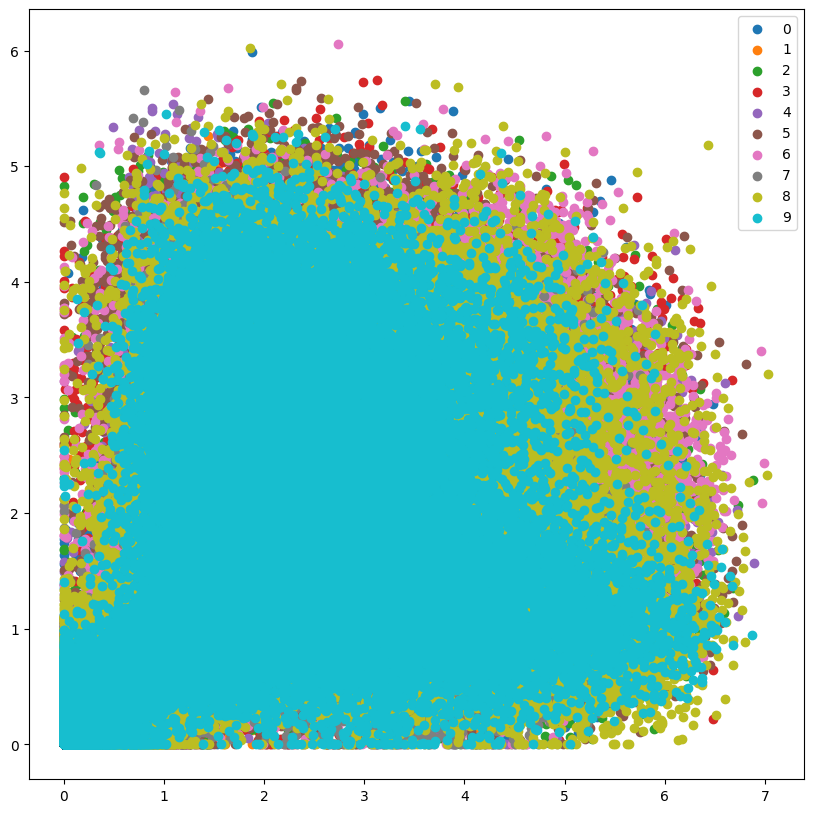

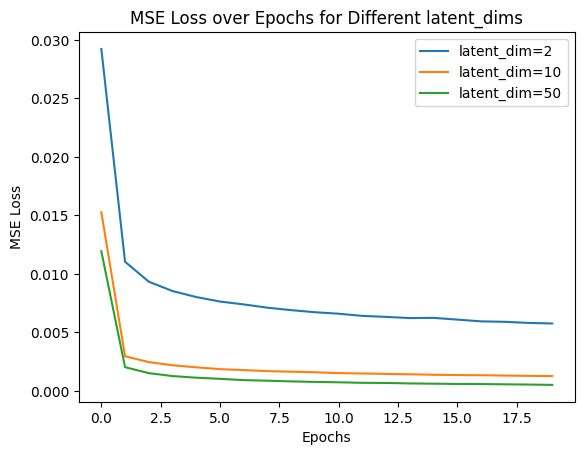

In [10]:
import matplotlib.pyplot as plt

# Define the number of training epochs and different latent dimensions to experiment with
num_epochs = 20
latent_dims = [2, 10, 50]  # Different latent dimensions to test
losses_per_dim = {}  # Dictionary to store losses for each latent dimension

# Loop over each latent dimension to train and evaluate models
for dim in latent_dims:
    print(f"Training with latent_dim = {dim}")
    
    # Train the AE_CNN model with the current latent dimension and store the losses
    losses = train_AE_CNN(num_epochs, dim)
    losses_per_dim[dim] = losses

# Plot the MSE loss over epochs for different latent dimensions
for latent_dim, losses in losses_per_dim.items():
    plt.plot(losses, label=f'latent_dim={latent_dim}')

# Configure plot labels and title
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('MSE Loss over Epochs for Different latent_dims')
plt.legend()
plt.show()


# Discussion-Part 1

<p>

<i>What can you say about the clustering of digits?</i>

- We think the digits did not cluster well. 

<i>Compare this to the fully-connected version from class?</i>

- The AutoEncoder with convolution showed more clear MNIST digits compared to the fully connected AutoEncoder.
- Therefore we think that the comparison shows that CNN-based autoencoders are better at capturing the spatial and local features of image data ending up with more distinct clustering in the latent space.

<i>Do you think the CNN-version of the AE is better??</i>

- In this scenario, we think it is safe to say that CNNs were better than Fully Connected AutoEncoders but in a more general case, CNNs might be more computationally expensive and complex to train compared to Fully Connected networks, especially for large images.

<i>Re-train the autoencoder with a latent space of d = 10 and d = 50 and compare the MSE-loss for all three autoencoders, as well as discuss the quality of reconstruction.</i>

- We found that a higher-dimensional latent space (e.g., latent_dim = 50) results in a lower MSE loss, as the network can capture more features of the input data. 
- However, the improvement in loss is not linear with the increase in dimensionality.

</p>




# Part2 Autoencoders vs GANs (30 points):
Still using the same notebook, add a DCGAN and train this on MNIST using a
comparable number of conv-layers, making sure to end up with DCGAN
architectures that use SIMILAR number of parameters compared to the
Neural Networks, Prof. C. Wallraven Page 2 of 2
autoencoders. Again, produce three different DCGAN models using generator
spaces of d = 2, d = 10, d = 50 training for n=20 epochs with properly set learning
rates.
Answer these questions:
1. Can you visualize the “latent” space of the DCGAN in the same way as the
autoencoder? Explain!
2. Which of the methods produces “better” digits?

In [11]:
import torch.nn as nn

class DiscriminatorNet(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        # Convolutional layers for feature extraction
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Output layer
        self.out = nn.Sequential(
            nn.Conv2d(128*4*4, latent_dim, kernel_size=1, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Flatten the output and apply sigmoid activation
        x = x.view(-1, 128 * 4 * 4, 1, 1)
        x = self.out(x)
        return x

    # Reset weights
    def reset(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.reset_parameters()
                # Initialize weights with a normal distribution
                m.weight.data.normal_(0.00, 0.02)


In [12]:
# init latent_dim
latent_dim = 2

def numpy_to_plotly(arr):
    # Normalize the input array to a range of [0, 255]
    tmp = (arr - arr.min()) / (arr.max() - arr.min()) * 255
    
    # Stack the normalized array along the third dimension to create an RGB image
    return np.dstack((tmp, tmp, tmp))

In [13]:
import torch.nn as nn

class GeneratorNet(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        # Initial linear layers to create a starting point for convolution
        self.conv0 = nn.ConvTranspose2d(latent_dim, 128 * 4 * 4, kernel_size=1, stride=1, padding=0)

        # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
        )
        
        # Output layer with Tanh activation
        self.out = nn.Tanh()

    def forward(self, x):
        # Reshape the input and apply the initial convolutional layer
        x = x.view(x.size(0), -1, 1, 1)
        x = self.conv0(x)
        x = x.view(x.shape[0], 128, 4, 4)

        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Apply Tanh activation to the output
        return self.out(x)

    # Reset weights
    def reset(self):
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                m.reset_parameters()
                # Initialize weights with a normal distribution
                m.weight.data.normal_(0.00, 0.02)


In [14]:
import torch

# Function to generate random noise
def noise(size, latent_dim):
    # Generate random noise as a torch tensor of size (size, latent_dim, 1, 1)
    n = torch.randn(size, latent_dim, 1, 1)
    
    # Check if CUDA (GPU) is available, and if so, move the noise tensor to the GPU
    if torch.cuda.is_available():
        return n.cuda()
    
    # If CUDA is not available, return the noise tensor on the CPU
    return n


In [15]:
import torch

# Function to generate real data target tensor containing ones
def real_data_target(size, latent_dim):
    data = torch.ones(size, latent_dim, 1, 1)
    if torch.cuda.is_available():
        return data.cuda()
    return data

# Function to generate fake data target tensor containing zeros
def fake_data_target(size, latent_dim):
    data = torch.zeros(size, latent_dim, 1, 1)
    if torch.cuda.is_available():
        return data.cuda()
    return data

# Function to train the discriminator network
def train_discriminator(optimizer, real_data, fake_data, latent_dim):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    # Error is measured against real data targets (ones)
    error_real = loss(prediction_real, real_data_target(real_data.size(0), latent_dim))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    # Error is measured against fake data targets (zeros)
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0), latent_dim))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error, prediction on real data, and prediction on fake data
    return error_real + error_fake, prediction_real, prediction_fake

# Function to train the generator network
def train_generator(optimizer, fake_data, latent_dim):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    # Error is measured against real data targets (ones)
    error = loss(prediction, real_data_target(prediction.size(0), latent_dim))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error


In [16]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from ipywidgets import interact
fig = make_subplots(rows=4, cols=4)

for i in range(4):
    for j in range(4):
        fig.append_trace(go.Image(z=np.zeros((32,32,3))),row=i+1,col=j+1)
fig = go.FigureWidget(fig)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)
fig


FigureWidget({
    'data': [{'type': 'image',
              'uid': 'ae30f175-eb12-4a39-9f45-1223923b394e',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.],
                           ...,
                           [0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.]],
                   
                          [[0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.],
                           ...,
                           [0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.]],
                   
                          [[0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.],
                           ...,
                           [0., 0., 0.],
                           [0., 0., 0.],
  

In [17]:
# Define latent dimensions to experiment with
latent_dims = [2, 10, 50]

# Create a dictionary to store losses for each latent dimension
losses_per_dim = {dim: {'discriminator': [], 'generator': []} for dim in latent_dims}

# Set the initial latent dimension
latent_dim = 2

# Instantiate the discriminator and generator networks
discriminator = DiscriminatorNet(latent_dim)
generator = GeneratorNet(latent_dim)

# Move networks to the GPU if available
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

# Define optimizers for the discriminator and generator
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Define the loss function (Binary Cross-Entropy)
loss = nn.BCELoss()

# Reset and initialize the weights of the discriminator and generator
discriminator.reset()
generator.reset()

# Number of epochs for training the GAN
num_epochs = 20

# Initialize variables for timing
t_start = time.time()
duration_avg = 0.0
num_test_samples = 50

# Generate test noise for visualization
test_noise = noise(num_test_samples, latent_dim)

# Main training loop
for epoch in range(num_epochs):
    for n_batch, real_data in enumerate(dataloader):
        # 1. Train Discriminator with real images
        if torch.cuda.is_available():
            real_data[0] = real_data[0].cuda()

        # Generate fake data from noise, do not update gradients here (detach)
        noise_input = noise(real_data[0].size(0), latent_dim)
        fake_data = generator(noise_input).detach()

        # Train discriminator with the real and fake data
        d_error, d_pred_real, d_pred_fake = train_discriminator(
            d_optimizer, real_data[0].float(), fake_data, latent_dim)

        # 2. Train Generator
        # Generate fake data from noise
        fake_data = generator(noise_input)

        # Train generator
        g_error = train_generator(g_optimizer, fake_data, latent_dim)

        # Record losses for discriminator and generator
        losses_per_dim[latent_dim]['discriminator'].append(d_error.item())
        losses_per_dim[latent_dim]['generator'].append(g_error.item())

        # Display progress and update Plotly figure
        if n_batch % 50 == 0:
            test_images = generator(test_noise).data.cpu()
            p = 0
            with fig.batch_update():
                for i in range(4):
                    for j in range(4):
                        tmp = test_images[p, 0, :, :].numpy()
                        fig.data[p]['z'] = numpy_to_plotly(tmp)
                        p += 1
            fig.update_layout(
                title={
                    'text': 'epoch {0:} batch {1:} L(D)={2:.3f} L(G)={3:.3f} t={4:.1f}s/it'.format(
                        epoch, n_batch, d_error, g_error, duration_avg),
                    'xanchor': 'center',
                    'x': 0.5
                })

    # Calculate and display average duration per iteration
    t_end = time.time()
    duration_avg = (t_end - t_start) / (epoch + 1.0)

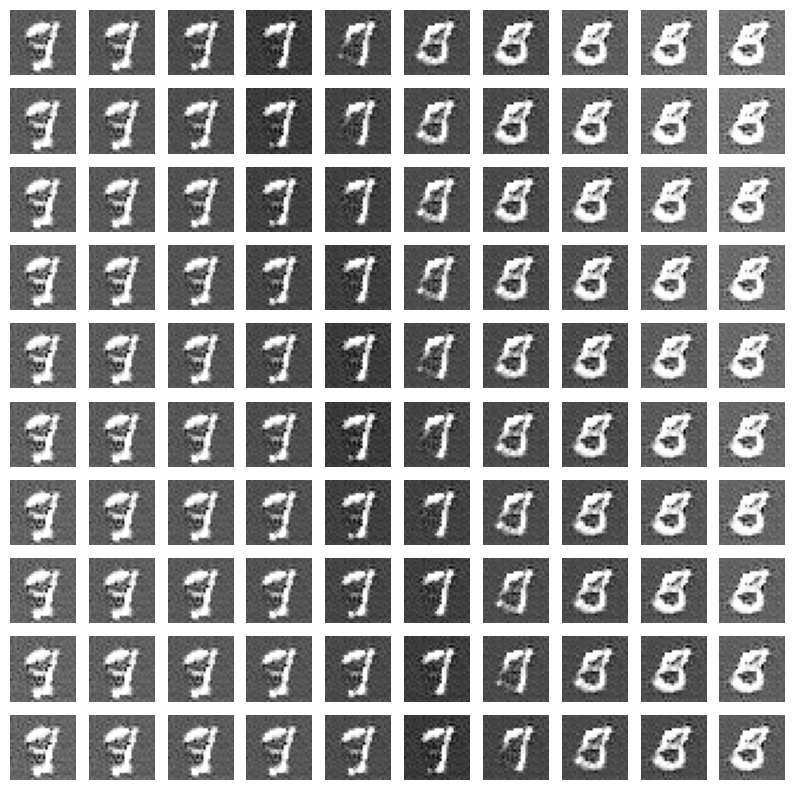

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Set the latent dimension to 2 
latent_dim = 2

# Create a grid of points in 2D latent space
n = 10  # Grid size
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)

# Create a grid of subplots for displaying generated images
fig, ax = plt.subplots(n, n, figsize=(10, 10))

# Loop through the grid points
for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        # Sample a point from the 2D latent space
        z_sample = torch.tensor([[xi, yi]], dtype=torch.float32)
        
        # Move the latent sample to GPU if available
        if torch.cuda.is_available():
            z_sample = z_sample.cuda()

        # Generate an image from the latent sample
        with torch.no_grad():
            generator.eval()  # Set the generator in evaluation mode
            generated_img = generator(z_sample).cpu().squeeze().numpy()

        # Display the generated image on the subplot
        ax[i, j].imshow(generated_img, cmap='gray')
        ax[i, j].axis('off')

# Show the grid of generated images
plt.show()


In [19]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from ipywidgets import interact
fig = make_subplots(rows=4, cols=4)

for i in range(4):
    for j in range(4):
        fig.append_trace(go.Image(z=np.zeros((32,32,3))),row=i+1,col=j+1)
fig = go.FigureWidget(fig)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)
fig


FigureWidget({
    'data': [{'type': 'image',
              'uid': 'a1516d60-9316-443b-a654-b8ea40233b09',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.],
                           ...,
                           [0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.]],
                   
                          [[0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.],
                           ...,
                           [0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.]],
                   
                          [[0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.],
                           ...,
                           [0., 0., 0.],
                           [0., 0., 0.],
  

In [20]:
latent_dim=10

# Instantiate the discriminator and generator networks
discriminator = DiscriminatorNet(latent_dim)
generator = GeneratorNet(latent_dim)

# Move networks to the GPU if available
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

# Define optimizers for the discriminator and generator
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Define the loss function (Binary Cross-Entropy)
loss = nn.BCELoss()

# Reset and initialize the weights of the discriminator and generator
discriminator.reset()
generator.reset()

# Number of epochs for training the GAN
num_epochs = 20

# Initialize variables for timing
t_start = time.time()
duration_avg = 0.0
num_test_samples = 50

# Generate test noise for visualization
test_noise = noise(num_test_samples, latent_dim)

# Main training loop
for epoch in range(num_epochs):
    for n_batch, real_data in enumerate(dataloader):
        # 1. Train Discriminator with real images
        if torch.cuda.is_available():
            real_data[0] = real_data[0].cuda()

        # Generate fake data from noise, do not update gradients here (detach)
        noise_input = noise(real_data[0].size(0), latent_dim)
        fake_data = generator(noise_input).detach()

        # Train discriminator with the real and fake data
        d_error, d_pred_real, d_pred_fake = train_discriminator(
            d_optimizer, real_data[0].float(), fake_data, latent_dim)

        # 2. Train Generator
        # Generate fake data from noise
        fake_data = generator(noise_input)

        # Train generator
        g_error = train_generator(g_optimizer, fake_data, latent_dim)

        # Record losses for discriminator and generator
        losses_per_dim[latent_dim]['discriminator'].append(d_error.item())
        losses_per_dim[latent_dim]['generator'].append(g_error.item())

        # Display progress and update Plotly figure
        if n_batch % 50 == 0:
            test_images = generator(test_noise).data.cpu()
            p = 0
            with fig.batch_update():
                for i in range(4):
                    for j in range(4):
                        tmp = test_images[p, 0, :, :].numpy()
                        fig.data[p]['z'] = numpy_to_plotly(tmp)
                        p += 1
            fig.update_layout(
                title={
                    'text': 'epoch {0:} batch {1:} L(D)={2:.3f} L(G)={3:.3f} t={4:.1f}s/it'.format(
                        epoch, n_batch, d_error, g_error, duration_avg),
                    'xanchor': 'center',
                    'x': 0.5
                })

    # Calculate and display average duration per iteration
    t_end = time.time()
    duration_avg = (t_end - t_start) / (epoch + 1.0)

In [21]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from ipywidgets import interact
fig = make_subplots(rows=4, cols=4)

for i in range(4):
    for j in range(4):
        fig.append_trace(go.Image(z=np.zeros((32,32,3))),row=i+1,col=j+1)
fig = go.FigureWidget(fig)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)
fig


FigureWidget({
    'data': [{'type': 'image',
              'uid': 'c76d65a7-3b64-4c43-ae14-b2a8ba52b894',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.],
                           ...,
                           [0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.]],
                   
                          [[0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.],
                           ...,
                           [0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.]],
                   
                          [[0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.],
                           ...,
                           [0., 0., 0.],
                           [0., 0., 0.],
  

In [22]:
latent_dim=50

# Instantiate the discriminator and generator networks
discriminator = DiscriminatorNet(latent_dim)
generator = GeneratorNet(latent_dim)

# Move networks to the GPU if available
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

# Define optimizers for the discriminator and generator
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Define the loss function (Binary Cross-Entropy)
loss = nn.BCELoss()

# Reset and initialize the weights of the discriminator and generator
discriminator.reset()
generator.reset()

# Number of epochs for training the GAN
num_epochs = 20

# Initialize variables for timing
t_start = time.time()
duration_avg = 0.0
num_test_samples = 50

# Generate test noise for visualization
test_noise = noise(num_test_samples, latent_dim)

# Main training loop
for epoch in range(num_epochs):
    for n_batch, real_data in enumerate(dataloader):
        # 1. Train Discriminator with real images
        if torch.cuda.is_available():
            real_data[0] = real_data[0].cuda()

        # Generate fake data from noise, do not update gradients here (detach)
        noise_input = noise(real_data[0].size(0), latent_dim)
        fake_data = generator(noise_input).detach()

        # Train discriminator with the real and fake data
        d_error, d_pred_real, d_pred_fake = train_discriminator(
            d_optimizer, real_data[0].float(), fake_data, latent_dim)

        # 2. Train Generator
        # Generate fake data from noise
        fake_data = generator(noise_input)

        # Train generator
        g_error = train_generator(g_optimizer, fake_data, latent_dim)

        # Record losses for discriminator and generator
        losses_per_dim[latent_dim]['discriminator'].append(d_error.item())
        losses_per_dim[latent_dim]['generator'].append(g_error.item())

        # Display progress and update Plotly figure
        if n_batch % 50 == 0:
            test_images = generator(test_noise).data.cpu()
            p = 0
            with fig.batch_update():
                for i in range(4):
                    for j in range(4):
                        tmp = test_images[p, 0, :, :].numpy()
                        fig.data[p]['z'] = numpy_to_plotly(tmp)
                        p += 1
            fig.update_layout(
                title={
                    'text': 'epoch {0:} batch {1:} L(D)={2:.3f} L(G)={3:.3f} t={4:.1f}s/it'.format(
                        epoch, n_batch, d_error, g_error, duration_avg),
                    'xanchor': 'center',
                    'x': 0.5
                })

    # Calculate and display average duration per iteration
    t_end = time.time()
    duration_avg = (t_end - t_start) / (epoch + 1.0)

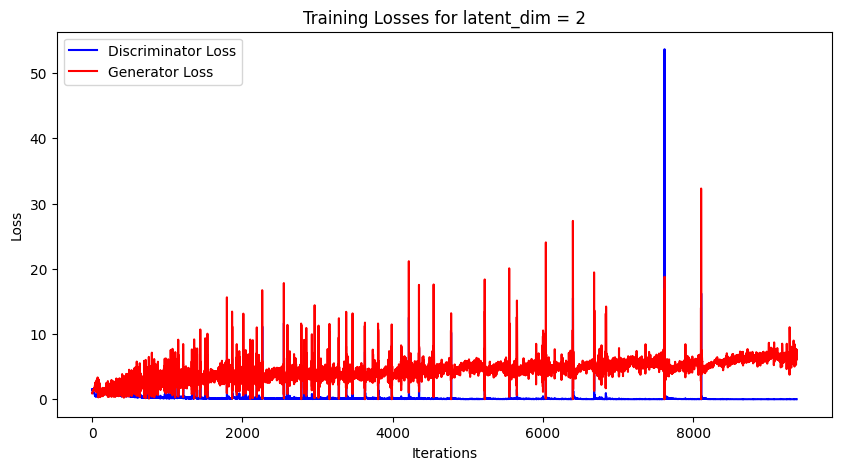

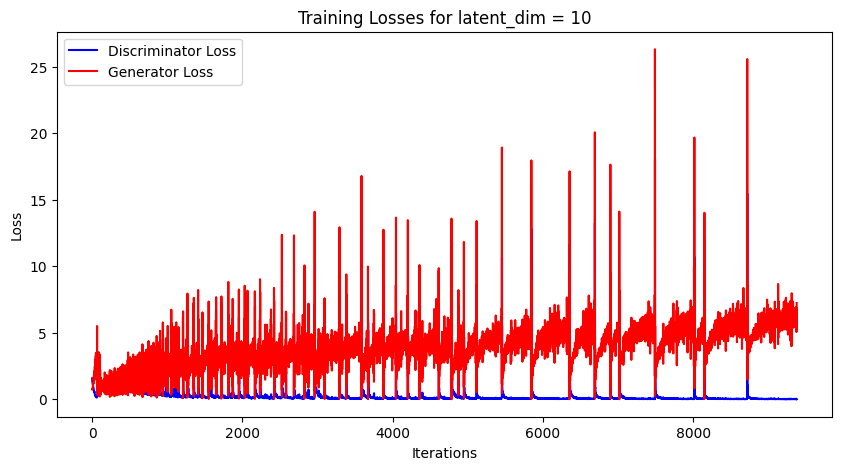

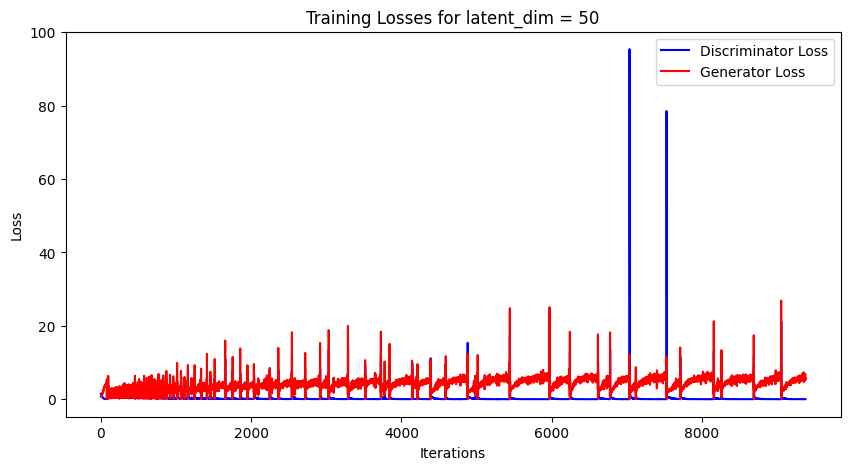

In [23]:
import matplotlib.pyplot as plt

# Assuming losses_per_dim is the dictionary you filled during training
for latent_dim, losses in losses_per_dim.items():
    plt.figure(figsize=(10, 5))
    
    # Plot Discriminator Loss
    plt.plot(losses['discriminator'], label='Discriminator Loss', color='blue')
    
    # Plot Generator Loss
    plt.plot(losses['generator'], label='Generator Loss', color='red')
    
    plt.title(f"Training Losses for latent_dim = {latent_dim}")
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


# Discussion Part 2

<p>
<i>Can you visualize the “latent” space of the DCGAN in the same way as the
autoencoder? Explain!</i>

- Creating a scatter plot from a GAN's generated images is not the same as an autoencoder. 
- This is because in GANs, each point in the latent space corresponds to a generated image not a data point that can be plotted in a scatter plot like an AutoEncoder.
- Also, visualizing the latent space of a GAN, especially for high-dimensional latent spaces (like latent_dim=50) is difficult compared to autoencoders. 
- In GANs, the generator's latent space does not usually have a well-structured, interpretable mapping to the output space in the same way an autoencoder's latent space does.
- In conclusion, we would say that we cannot visualize the "latent" space of the DCGAN in the same way as the AutoEncoder.


<i>Which of the methods produces “better” digits?</i>

- We think this is because AEs typically have a more stable training process than GANs
- AEs learn to generate data by directly learning to reconstruct their input data. 
- This results in good performance on tasks like MNIST digit generation, where the goal is to produce outputs that closely resemble the inputs. 
- Also, GANs may not organize their latent space as neatly, making controlled sample generation more difficult.
- But GANs have their strength elsewhere like in more visually appealing images in more complex datasets
- So in conclusion, we would say that AutoEncoders produce better MNIST digits.


</p>